<h1> Calibration Comparison V1 </h1>

In [72]:
import json, os
import cv2
import torch
from multiprocessing import Pool, Manager
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.akpd import AKPD
from aquabyte.template_matching import find_matches_and_homography
from aquabyte.biomass_estimator import NormalizeCentered2D, NormalizedStabilityTransform, ToTensor, Network
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
from aquabyte.data_loader import BODY_PARTS
from aquabyte.akpd_scorer import generate_confidence_score
from keras.models import load_model
import boto3
import pandas as pd
from PIL import Image
from collections import defaultdict

import numpy as np
from matplotlib import pyplot as plt
import time

pd.set_option('display.max_colwidth', 500)

<h1> Load and Clean Data </h1>

In [2]:
matlab_csv_s3_url = 'https://aquabyte-calibrations.s3-eu-west-1.amazonaws.com/biomass_experiments/biomass.matlab.imr.pen-61-from-2019-09-13-to-2019-09-23.results.csv'
s3_access_utils = S3AccessUtils('/root/data')
matlab_csv_f, bucket, key = s3_access_utils.download_from_url(matlab_csv_s3_url)
matlab_df = pd.read_csv(matlab_csv_f)


In [4]:
circular_csv_s3_url = 'https://aquabyte-calibrations.s3-eu-west-1.amazonaws.com/biomass_experiments/biomass.circular.imr.pen-61-from-2019-09-13-to-2019-09-23.results.csv'
s3_access_utils = S3AccessUtils('/root/data')
circular_csv_f, bucket, key = s3_access_utils.download_from_url(circular_csv_s3_url)
circular_df = pd.read_csv(circular_csv_f)


/root/data/s3/aquabyte-calibrations/biomass_experiments/biomass.circular.imr.pen-61-from-2019-09-13-to-2019-09-23.results.csv


In [50]:
mdf = matlab_df.copy(deep=True)
cdf = circular_df.copy(deep=True)
common_urls = list(set(mdf.left_crop_url).intersection(set(cdf.left_crop_url)))
mdf = mdf[mdf.left_crop_url.isin(common_urls)].sort_values(['captured_at', 'left_crop_url']).copy(deep=True)
cdf = cdf[cdf.left_crop_url.isin(common_urls)].sort_values(['captured_at', 'left_crop_url']).copy(deep=True)
df = pd.DataFrame({
    'captured_at': mdf.captured_at,
    'weight_m': mdf.estimated_weight_g.values,
    'weight_c': cdf.estimated_weight_g.values,
    'akpd_score_m': mdf.akpd_score.values,
    'akpd_score_c': cdf.akpd_score.values,
    'left_crop_url_m': mdf.left_crop_url.values,
    'right_crop_url_m': mdf.right_crop_url.values,
    'left_crop_url_c': cdf.left_crop_url.values,
    'right_crop_url_c': cdf.right_crop_url.values,
    'ann_m': mdf.annotation.values,
    'ann_c': cdf.annotation.values
})

df = df[(df.akpd_score_m > 0.9) & (df.akpd_score_c > 0.9)].copy(deep=True)

<h1> Perform Un- and Re-Rectification </h1>

In [58]:
def load_params(params_file):
    params = json.load(open(params_file))
    cameraMatrix1 = np.array(params['CameraParameters1']['IntrinsicMatrix']).transpose()
    cameraMatrix2 = np.array(params['CameraParameters2']['IntrinsicMatrix']).transpose()

    distCoeffs1 = params['CameraParameters1']['RadialDistortion'][0:2] + \
                   params['CameraParameters1']['TangentialDistortion'] + \
                   [params['CameraParameters1']['RadialDistortion'][2]]
    distCoeffs1 = np.array(distCoeffs1)

    distCoeffs2 = params['CameraParameters2']['RadialDistortion'][0:2] + \
                   params['CameraParameters2']['TangentialDistortion'] + \
                   [params['CameraParameters2']['RadialDistortion'][2]]
    distCoeffs2 = np.array(distCoeffs2)

    R = np.array(params['RotationOfCamera2']).transpose()
    T = np.array(params['TranslationOfCamera2']).transpose()

    imageSize = (4096, 3000)
    
    # perform rectification
    (R1, R2, P1, P2, Q, leftROI, rightROI) = cv2.stereoRectify(cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, imageSize, R, T, None, None, None, None, None, cv2.CALIB_ZERO_DISPARITY, 0)
    

    left_maps = cv2.initUndistortRectifyMap(cameraMatrix1, distCoeffs1, R1, P1, imageSize, cv2.CV_16SC2)
    right_maps = cv2.initUndistortRectifyMap(cameraMatrix2, distCoeffs2, R2, P2, imageSize, cv2.CV_16SC2)
    
    return left_maps, right_maps, cameraMatrix1, distCoeffs1, R1, P1

In [60]:
matlab_params_url = 'https://aquabyte-stereo-parameters.s3-eu-west-1.amazonaws.com/L40013180_R40029775/2020-01-14T00:00:00Z_L40013180_R40029775_stereo-parameters.json'
circular_params_url = 'https://aquabyte-stereo-parameters.s3-eu-west-1.amazonaws.com/L40013180_R40029775/2020-02-16T17:30:33.458096000Z_L40013180_R40029775_stereo-parameters.json'
matlab_params_f, _, _ = s3_access_utils.download_from_url(matlab_params_url)
circular_params_f, _, _ = s3_access_utils.download_from_url(circular_params_url)
left_maps_m, right_maps_m, cameraMatrix1_m, distCoeffs1_m, R1_m, P1_m = load_params(matlab_params_f)
left_maps_c, right_maps_c, cameraMatrix1_c, distCoeffs1_c, R1_c, P1_c = load_params(circular_params_f)

In [91]:
ann_m_mp_c_cp_m_list = []
for idx, row in df.iterrows():
    ann_m = json.loads(row.ann_m)
    
    # un-rectify with matlab params, re-rectify with circular params
    ann_m_mp_c = {'leftCrop': [], 'rightCrop': []}
    for side in ['leftCrop', 'rightCrop']:
        for item in ann_m[side]:
            bp = item['keypointType']
            x, y = item['xFrame'], item['yFrame']
            maps = left_maps_m if side == 'leftCrop' else right_maps_m
            x_new, y_new = cv2.undistortPoints(np.array([[maps[0][y, x]]]).astype(float), 
                                cameraMatrix1_c, distCoeffs1_c, R=R1_c, P=P1_c)[0][0]
            x_new, y_new = int(round(x_new)), int(round(y_new))
            ann_m_mp_c[side].append({
                'keypointType': bp,
                'xFrame': x_new,
                'yFrame': y_new
            })
            
    
    # now take above result, un-rectify with circular params, re-rectify with matlab params
    ann_m_mp_c_cp_m = {'leftCrop': [], 'rightCrop': []}
    for side in ['leftCrop', 'rightCrop']:
        for item in ann_m_mp_c[side]:
            bp = item['keypointType']
            x, y = item['xFrame'], item['yFrame']
            maps = left_maps_c if side == 'leftCrop' else right_maps_c
            x_new, y_new = cv2.undistortPoints(np.array([[maps[0][y, x]]]).astype(float), 
                                cameraMatrix1_m, distCoeffs1_m, R=R1_m, P=P1_m)[0][0]
            x_new, y_new = int(round(x_new)), int(round(y_new))
            ann_m_mp_c_cp_m[side].append({
                'keypointType': bp,
                'xFrame': x_new,
                'yFrame': y_new
            })

    ann_m_mp_c_cp_m_list.append(ann_m_mp_c_cp_m)
    break

leftCrop
leftCrop
leftCrop
leftCrop
leftCrop
leftCrop
leftCrop
leftCrop
rightCrop
rightCrop
rightCrop
rightCrop
rightCrop
rightCrop
rightCrop
rightCrop


In [76]:
analysis_data = defaultdict(list)
for ann_m, ann_m_mp_c_cp_m in zip([json.loads(x) for x in list(df.ann_m.values)], ann_m_mp_c_cp_m_list):
    ann_m_left_kps = {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann_m['leftCrop']}
    ann_m_right_kps = {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann_m['rightCrop']}
    ann_m_mp_c_cp_m_left_kps = \
        {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann_m_mp_c_cp_m['leftCrop']}
    ann_m_mp_c_cp_m_right_kps = \
        {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann_m_mp_c_cp_m['rightCrop']}
    for bp in BODY_PARTS:
        analysis_data['body_part'].append(bp)
        analysis_data['x_1_l'].append(ann_m_left_kps[bp][0])
        analysis_data['y_1_l'].append(ann_m_left_kps[bp][1])
        analysis_data['x_1_r'].append(ann_m_right_kps[bp][0])
        analysis_data['y_1_r'].append(ann_m_right_kps[bp][1])
        analysis_data['x_2_l'].append(ann_m_mp_c_cp_m_left_kps[bp][0])
        analysis_data['y_2_l'].append(ann_m_mp_c_cp_m_left_kps[bp][1])
        analysis_data['x_2_r'].append(ann_m_mp_c_cp_m_right_kps[bp][0])
        analysis_data['y_2_r'].append(ann_m_mp_c_cp_m_right_kps[bp][1])
        
    

In [77]:
analysis_df = pd.DataFrame(analysis_data)

In [87]:
for bp in BODY_PARTS:
    body_part_mask = analysis_df.body_part == bp
    diffs = analysis_df[body_part_mask].x_1_l - analysis_df[body_part_mask].x_2_l
    print('Diffs in left crop x coordinate for {}: {}'.format(bp, diffs.abs().mean()))
    
    diffs = analysis_df[body_part_mask].y_1_l - analysis_df[body_part_mask].y_2_l
    print('Diffs in left crop y coordinate for {}: {}'.format(bp, diffs.abs().mean()))
    
    diffs = analysis_df[body_part_mask].x_1_r - analysis_df[body_part_mask].x_2_r
    print('Diffs in right crop x coordinate for {}: {}'.format(bp, diffs.abs().mean()))
    
    diffs = analysis_df[body_part_mask].y_1_r - analysis_df[body_part_mask].y_2_r
    print('Diffs in right crop y coordinate for {}: {}'.format(bp, diffs.abs().mean()))

Diffs in left crop x coordinate for ADIPOSE_FIN: 0.9798468359532446
Diffs in left crop y coordinate for ADIPOSE_FIN: 0.9985892785167271
Diffs in right crop x coordinate for ADIPOSE_FIN: 11.296251511487304
Diffs in right crop y coordinate for ADIPOSE_FIN: 29.073559048770658
Diffs in left crop x coordinate for ANAL_FIN: 0.9806529625151149
Diffs in left crop y coordinate for ANAL_FIN: 0.9840790004030633
Diffs in right crop x coordinate for ANAL_FIN: 10.930471584038694
Diffs in right crop y coordinate for ANAL_FIN: 30.806731156791617
Diffs in left crop x coordinate for DORSAL_FIN: 0.9937525191455059
Diffs in left crop y coordinate for DORSAL_FIN: 0.9925433293027005
Diffs in right crop x coordinate for DORSAL_FIN: 9.36074163643692
Diffs in right crop y coordinate for DORSAL_FIN: 28.87968561064087
Diffs in left crop x coordinate for EYE: 0.9907295445384925
Diffs in left crop y coordinate for EYE: 0.9806529625151149
Diffs in right crop x coordinate for EYE: 8.945183393792826
Diffs in right cr

In [116]:
diffs = []
for idx, row in df.iterrows():
    ann_m = json.loads(row.ann_m)
    ann_dict_left_kps_m = {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann_m['leftCrop']}
    ann_dict_right_kps_m = {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann_m['rightCrop']}
    for bp in BODY_PARTS:
        diff = ann_dict_left_kps_m[bp][1] - ann_dict_right_kps_m[bp][1]
        diffs.append(diff)

print(np.median(diffs))

16.0


In [117]:
diffs = []
for idx, row in df.iterrows():
    ann_c = json.loads(row.ann_c)
    ann_dict_left_kps_c = {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann_c['leftCrop']}
    ann_dict_right_kps_c = {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann_c['rightCrop']}
    for bp in BODY_PARTS:
        diff = ann_dict_left_kps_c[bp][1] - ann_dict_right_kps_c[bp][1]
        diffs.append(diff)
print(np.median(diffs))

14.0


In [120]:
diffs = []
for idx, row in cdf[cdf.akpd_score > 0.9].iterrows():
    ann_c = json.loads(row.annotation)
    ann_dict_left_kps_c = {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann_c['leftCrop']}
    ann_dict_right_kps_c = {item['keypointType']: [item['xFrame'], item['yFrame']] for item in ann_c['rightCrop']}
    for bp in BODY_PARTS:
        diff = ann_dict_left_kps_c[bp][1] - ann_dict_right_kps_c[bp][1]
        diffs.append(diff)
print(np.median(diffs))

14.0


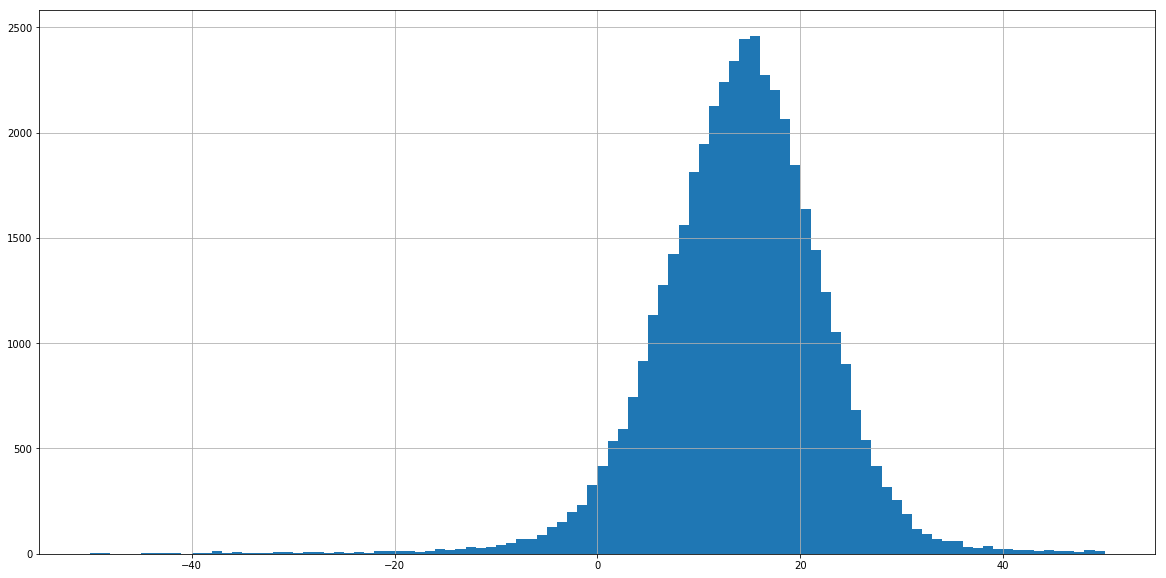

In [121]:
plt.figure(figsize=(20, 10))
plt.hist(diffs, bins=100)
plt.grid()
plt.show()